In [9]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from itertools import combinations
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
sns.set()

# ***Budget data*** ข้อมูลคอร์สนี้เอาไปทำใหม่ยาก

## ***Code [อยู่ที่นี่](https://github.com/datacamp/course-resources-ml-with-experts-budgets/blob/master/notebooks/1.0-full-model.ipynb)***

* **Line-item**: "Algebra books for 8th grade students"
* **Labels**: "Textbooks", "Math", "Middle School"

* This is a classification problem

### ***Encode the labels as categorical variables***

Remember, your ultimate goal is to predict the probability that a certain label is attached to a budget line item. You just saw that many columns in your data are the inefficient object type. Does this include the labels you're trying to predict? Let's find out!

There are 9 columns of labels in the dataset. Each of these columns is a category that has many possible values it can take. The 9 labels have been loaded into a list called `LABELS`. In the Shell, check out the type for these labels using `df[LABELS].dtypes`.

You will notice that every label is encoded as an `object` datatype. Because category datatypes are much more efficient your task is to convert the labels to category types using the `.astype()` method.

Note: `.astype()` only works on a pandas Series. Since you are working with a pandas DataFrame, you'll need to use the `.apply()` method and provide a lambda function called `categorize_label` that applies `.astype()` to each column, `x`.

* Define the `lambda` function `categorize_label` to convert column `x` into `x.astype('category')`.

* Use the `LABELS` list provided to convert the subset of data `df[LABELS]` to categorical types using the `.apply()` method and `categorize_label`. Don't forget `axis=0`.

* Print the converted `.dtypes` attribute of `df[LABELS]`.

In [ ]:
# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
print(df[LABELS].dtypes)

### ***Counting unique labels***

There are over 100 unique labels. Explore this fact by counting and plotting the number of unique values for each category of label.

The dataframe `df` and the `LABELS` list have been loaded into the workspace; the `LABELS` columns of `df` have been converted to category types.

pandas, which has been pre-imported as `pd`, provides a `pd.Series.nunique` method for counting the number of unique values in a Series.

* Create the DataFrame `num_unique_labels` by using the `.apply()` method on df`[LABELS]` with `pd.Series.nunique` as the `argument`.

* Create a bar plot of `num_unique_labels` using pandas' `.plot(kind='bar')` method.



In [ ]:
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']
df[LABELS].nunique()




```
Function            37
Use                  8
Sharing              5
Reporting            3
Student_Type         9
Position_Type       25
Object_Type         11
Pre_K                3
Operating_Status     3
dtype: int64
```



In [ ]:
# Import matplotlib.pyplot
import matplotlib.pyplot as plt

# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].nunique()

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

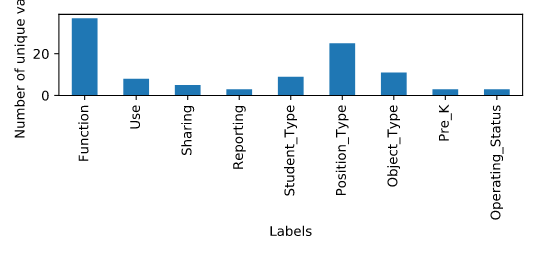

That's a lot of labels to work with. How will you measure success with these many labels?

# ***Log loss binary classification***

* $$logloss = -\frac{1}{N}\sum_{i=1}^N(y_i\log(p_i) + (1-y_i)\log(1-p_i))$$
  * Actual value: $y$ (1 = yes, 0 = no)
  * Prediction (probability that the value is 1): $p$

In [3]:
def compute_log_loss(predicted, actual, eps=1e-14):
    """ Computes the logarithmic loss between predicted and
        actual when these are 1D arrays.

        :param predicted: The predicted probabilities as floats between 0-1
        :param actual: The actual binary labels. Either 0 or 1.
        :param eps (optional): log(0) is inf, so we need to offset our
                          predicted values slightly by eps from 0 or 1.
    """
    predicted = np.clip(predicted, eps, 1 - eps)
    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual)*np.log(1 - predicted))
    return loss

### ***Computing log loss with NumPy***

To see how the log loss metric handles the trade-off between accuracy and confidence, we will use some sample data generated with NumPy and compute the log loss using the provided function `compute_log_loss()`.

5 one-dimensional numeric arrays simulating different types of predictions have been pre-loaded: `actual_labels`, `correct_confident`, `correct_not_confident`, `wrong_not_confident`, and `wrong_confident`.

Your job is to compute the log loss for each sample set provided using the `compute_log_loss(predicted_values, actual_values)`. It takes the predicted values as the first argument and the actual values as the second argument.

* Using the `compute_log_loss()` function, compute the log loss for the following predicted values (in each case, the actual values are contained in `actual_labels`):

* `correct_confident`.
* `correct_not_confident`.
* `wrong_not_confident`.
* `wrong_confident`.
* `actual_labels`.

In [6]:
from numpy import array
actual_labels = array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])
correct_confident = array([0.95, 0.95, 0.95, 0.95, 0.95, 0.05, 0.05, 0.05, 0.05, 0.05])
correct_not_confident = array([0.65, 0.65, 0.65, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35, 0.35])
wrong_not_confident = array([0.35, 0.35, 0.35, 0.35, 0.35, 0.65, 0.65, 0.65, 0.65, 0.65])
wrong_confident = array([0.05, 0.05, 0.05, 0.05, 0.05, 0.95, 0.95, 0.95, 0.95, 0.95])

a = [correct_confident, correct_not_confident, wrong_not_confident, wrong_confident, actual_labels]
b = ['correct and confident', 'correct and not confident', 'wrong and not confident', 'wrong and confident', 'actual labels']

for i, j in zip(a, b):
    loss = compute_log_loss(i, actual_labels)
    print(f"Log loss, {j}: {loss:,.2f}") 

Log loss, correct and confident: 0.05
Log loss, correct and not confident: 0.43
Log loss, wrong and not confident: 1.05
Log loss, wrong and confident: 3.00
Log loss, actual labels: 0.00


Log loss penalizes highly ***confident wrong*** answers much more than any other type. This will be a good metric to use on your models.

# ***ข้อมูลมีตัวแปรตาม (`LABELS`) หลายตัวมากๆ***

### ***Setting up a train-test split in scikit-learn***

The first step is to split the data into a training set and a test set. Some labels don't occur very often, but we want to make sure that they appear in both the training and the test sets. We provide a function that will make sure at least `min_count` examples of each label appear in each split: `multilabel_train_test_split`.

Feel free to check out the full code for multilabel_train_test_split [here](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/data/multilabel.py).

You'll start with a simple model that uses just the numeric columns of your DataFrame when calling `multilabel_train_test_split`. The data has been read into a DataFrame `df` and a list consisting of just the numeric columns is available as `NUMERIC_COLUMNS`.

* Create a new DataFrame named `numeric_data_only` by applying the **`.fillna(-1000)`** method to the numeric columns (available in the list `NUMERIC_COLUMNS`) of `df`.

* Convert the labels (available in the list `LABELS`) to dummy variables. Save the result as `label_dummies`.

* In the call to `multilabel_train_test_split()`, set the size of your test set to be `0.2`. Use a seed of `123`.

* Fill in the **`.info()`** method calls for `X_train`, `X_test`, `y_train`, and `y_test`.

In [8]:
from warnings import warn
import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')
    
    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')
    
    if size <= 1:
        size = np.floor(y.shape[0] * size)
    
    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count
    
    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))
    
    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])
    
    sample_idxs = np.array([], dtype=choices.dtype)
    
    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])
        
    sample_idxs = np.unique(sample_idxs)
        
    # now that we have at least min_count of each, we can just random sample
    sample_count = size - sample_idxs.shape[0]
    
    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices, size=sample_count, replace=False)
        
    return np.concatenate([sample_idxs, remaining_sampled]) 

def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)    
    train_set_idxs = np.setdiff1d(index, test_set_idxs)
    
    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask
    
    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [ ]:
# Create the new DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,label_dummies, size=0.2, seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 




```
df[NUMERIC_COLUMNS].fillna(-1000) = 

                FTE          Total
198    -1000.000000   -8291.860000
209    -1000.000000     618.290000
750        1.000000   49768.820000
931    -1000.000000      -1.020000
1524   -1000.000000    2304.430000
1770   -1000.000000    1505.850000
```

```
df[LABELS] = 
                                               Function                          Use                    Sharing   Reporting       Student_Type            Position_Type                  Object_Type     Pre_K   Operating_Status
198                                            NO_LABEL                     NO_LABEL                   NO_LABEL    NO_LABEL           NO_LABEL                 NO_LABEL                     NO_LABEL  NO_LABEL      Non-Operating
209                              Student Transportation                     NO_LABEL            Shared Services  Non-School           NO_LABEL                 NO_LABEL       Other Non-Compensation  NO_LABEL  PreK-12 Operating
750                                Teacher Compensation                  Instruction            School Reported      School        Unspecified                  Teacher     Base Salary/Compensation  Non PreK  PreK-12 Operating
931                                            NO_LABEL                     NO_LABEL                   NO_LABEL    NO_LABEL           NO_LABEL                 NO_LABEL                     NO_LABEL  NO_LABEL      Non-Operating
1524                                           NO_LABEL                     NO_LABEL                   NO_LABEL    NO_LABEL           NO_LABEL                 NO_LABEL                     NO_LABEL  NO_LABEL      Non-Operating
1770                                         Enrichment  Pupil Services & Enrichment            School Reported      School        Unspecified       Club Advisor/Coach   Other Compensation/Stipend  NO_LABEL  PreK-12 Operating

pd.get_dummies(df[LABELS]) = 

        Function_Aides Compensation  Function_Career & Academic Counseling  Function_Communications  Function_Curriculum Development  Function_Data Processing & Information Services  Function_Development & Fundraising  ...  Pre_K_NO_LABEL  Pre_K_Non PreK  Pre_K_PreK  Operating_Status_Non-Operating  Operating_Status_Operating, Not PreK-12  Operating_Status_PreK-12 Operating
198                               0                                      0                        0                                0                                                0                                   0  ...               1               0           0                               1                                        0                                   0
209                               0                                      0                        0                                0                                                0                                   0  ...               1               0           0                               0                                        0                                   1
750                               0                                      0                        0                                0                                                0                                   0  ...               0               1           0                               0                                        0                                   1
931                               0                                      0                        0                                0                                                0                                   0  ...               1               0           0                               1                                        0                                   0
1524                              0                                      0                        0                                0                                                0                                   0  ...               1               0           0                               1                                        0                                   0



```

```
<script.py> output:
    X_train info:
    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 1040 entries, 198 to 101861
    Data columns (total 2 columns):
    FTE      1040 non-null float64
    Total    1040 non-null float64
    dtypes: float64(2)
    memory usage: 24.4 KB
    None
    
    X_test info:
    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 520 entries, 209 to 448628
    Data columns (total 2 columns):
    FTE      520 non-null float64
    Total    520 non-null float64
    dtypes: float64(2)
    memory usage: 12.2 KB
    None
    
    y_train info:
    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 1040 entries, 198 to 101861
    Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
    dtypes: uint8(104)
    memory usage: 113.8 KB
    None
    
    y_test info:
    <class 'pandas.core.frame.DataFrame'>
    Int64Index: 520 entries, 209 to 448628
    Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
    dtypes: uint8(104)
    memory usage: 56.9 KB
    None
```



### ***Training a model***

Import the logistic regression and one versus rest classifiers in order to fit a multi-class logistic regression model to the `NUMERIC_COLUMNS` of your feature data.

Then you'll test and print the accuracy with the **`.score()`** method to see the results of training.

**Before you train!** Remember, we're ultimately going to be using logloss to score our model, so don't worry too much about the accuracy here. Keep in mind that you're throwing away all of the text data in the dataset - that's by far most of the data! So don't get your hopes up for a killer performance just yet. We're just interested in getting things up and running at the moment.

All data necessary to call `multilabel_train_test_split()` has been loaded into the workspace.

* Instantiate the classifier `clf` by placing **`LogisticRegression()`** inside **`OneVsRestClassifier()`**.

* Fit the classifier to the training data `X_train` and `y_train`.

* Compute and print the accuracy of the classifier using its **`.score()`** method, which accepts two arguments: `X_test` and `y_test`.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Create the DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))



```
<script.py> output:
    Accuracy: 0.0
```

The good news is that your workflow didn't cause any errors. The bad news is that your model scored the lowest possible accuracy: **0.0**! But hey, you just threw away ALL of the text data in the budget. Later, you won't. Before you add the text data, let's see how the model does when scored by log loss.

# ***Predicting on holdout data***

In [ ]:
holdout = pd.read_csv('HoldoutData.csv', index_col=0)
holdout = holdout[NUMERIC_COLUMNS].fillna(-1000)
predictions = clf.predict_proba(holdout)

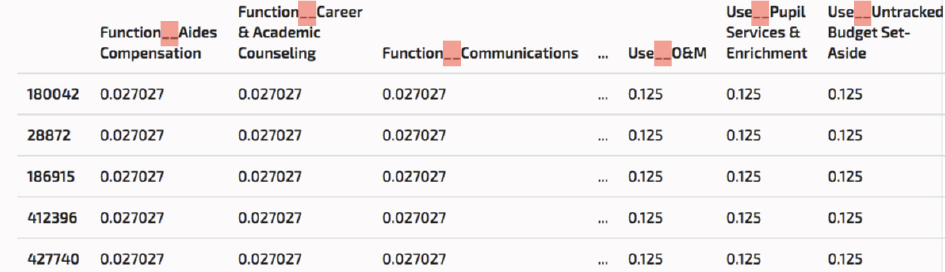

# ***Format and submit predictions***

In [ ]:
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, # double underscores
                             index=holdout.index,
                             data=predictions)

prediction_df.to_csv('predictions.csv')
score = score_submission(pred_path='predictions.csv') # score_submission  function is provided

### ***Use your model to predict values on holdout data***

## งงๆกับอันนี้ เพราะว่าเป็นการทำนายความน่าจะเป็นของตัวแปรตามที่เป็นตัวเลข ?  ซึ่งปกติจะต้องเป็น classifier

You're ready to make some predictions! Remember, the train-test-split you've carried out so far is for model development. The original competition provides an additional test set, for which you'll never actually see the correct labels. This is called the "holdout data."

The point of the holdout data is to provide a fair test for machine learning competitions. If the labels aren't known by anyone but DataCamp, DrivenData, or whoever is hosting the competition, you can be sure that no one submits a mere copy of labels to artificially pump up the performance on their model.

Remember that the original goal is ***to predict the probability of each label.*** In this exercise you'll do just that by using the **`.predict_proba()`** method on your trained model.

First, however, you'll need to load the holdout data, which is available in the workspace as the file `HoldoutData.csv`.

* Read `HoldoutData.csv` into a DataFrame called `holdout`. Specify the keyword argument **`index_col=0`** in your call to `read_csv()`.

* Generate predictions using **`.predict_proba()`** on the numeric columns (available in the `NUMERIC_COLUMNS` list) of `holdout`. Make sure to fill in missing values with `-1000`!

In [ ]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit it to the training data
clf.fit(X_train, y_train)

# Load the holdout data: holdout
holdout = pd.read_csv('HoldoutData.csv', index_col=0)

# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

Now you can write the predictions to a `.csv` and submit for scoring.

### ***Writing out your results to a csv for submission***

At last, you're ready to submit some predictions for scoring. In this exercise, you'll write your predictions to a `.csv` using the **`.to_csv()`** method on a pandas DataFrame. Then you'll evaluate your performance according to the LogLoss metric discussed earlier!

You'll need to make sure your submission obeys the correct format.

To do this, you'll use your predictions values to create a new DataFrame, `prediction_df`.

Interpreting LogLoss & Beating the Benchmark:

When interpreting your log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare your score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. Is your model's log loss lower than 2.0455?

* Create the `prediction_df` DataFrame by specifying the following arguments to the provided parameters `pd.DataFrame()`:
  * `pd.get_dummies(df[LABELS]).columns`.
  * `holdout.index`.
  * `predictions`.

Save `prediction_df` to a csv file called `'predictions.csv'` using the `.to_csv()` method.

* Submit the predictions for scoring by using the `score_submission()` function with `pred_path` set to `'predictions.csv'`.

In [ ]:
def score_submission(pred_path=PATH_TO_PREDICTIONS, holdout_path=PATH_TO_HOLDOUT_LABELS):
    
    # this happens on the backend to get the score
    holdout_labels = pd.get_dummies(
                        pd.read_csv(holdout_path, index_col=0)
                          .apply(lambda x: x.astype('category'), axis=0)
                      )

    preds = pd.read_csv(pred_path, index_col=0)
    
    # make sure that format is correct
    assert (preds.columns == holdout_labels.columns).all()
    assert (preds.index == holdout_labels.index).all()

    return _multi_multi_log_loss(preds.values, holdout_labels.values)

def _multi_multi_log_loss(predicted,
                          actual,
                          class_column_indices=BOX_PLOTS_COLUMN_INDICES,
                          eps=1e-15):
    """ Multi class version of Logarithmic Loss metric as implemented on
        DrivenData.org
    """
    class_scores = np.ones(len(class_column_indices), dtype=np.float64)

    # calculate log loss for each set of columns that belong to a class:
    for k, this_class_indices in enumerate(class_column_indices):
        # get just the columns for this class
        preds_k = predicted[:, this_class_indices].astype(np.float64)

        # normalize so probabilities sum to one (unless sum is zero, then we clip)
        preds_k /= np.clip(preds_k.sum(axis=1).reshape(-1, 1), eps, np.inf)

        actual_k = actual[:, this_class_indices]

        # shrink predictions so
        y_hats = np.clip(preds_k, eps, 1 - eps)
        sum_logs = np.sum(actual_k * np.log(y_hats))
        class_scores[k] = (-1.0 / actual.shape[0]) * sum_logs

    return np.average(class_scores)

In [ ]:
# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)


# Save prediction_df to csv
prediction_df.to_csv('predictions.csv')

# Submit the predictions for scoring: score
score = score_submission(pred_path='predictions.csv')

# Print score
print('Your model, trained with numeric data only, yields logloss score: {}'.format(score))

Even though your basic model scored 0.0 accuracy, it nevertheless performs better than the benchmark score of 2.0455. You've now got the basics down and have made a first pass at this complicated supervised learning problem. It's time to step up your game and incorporate the text data.

# ***Tokenization***

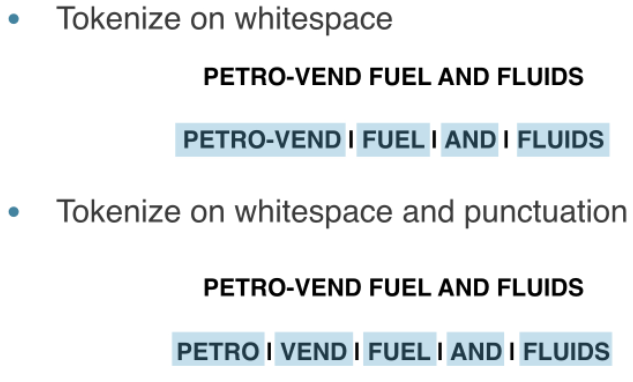

# ***Using `CountVectorizer()` on column of main dataset***

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

TOKENS_BASIC = '\\\\S+(?=\\\\s+)'
df.Program_Description.fillna('', inplace=True)
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

vec_basic.fit(df.Program_Description)



```
CountVectorizer(analyzer='word', binary=False, decode_error='strict',
dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
lowercase=True, max_df=1.0, max_features=None, min_df=1,
ngram_range=(1, 1), preprocessor=None, stop_words=None,
strip_accents=None, token_pattern='\\S+(?=\\s+)',
tokenizer=None, vocabulary=None)
```



In [ ]:
msg = 'There are {} tokens in Program_Description if tokens are any non-whitespace'
print(msg.format(len(vec_basic.get_feature_names())))



```
There are 157 tokens in Program_Description if tokens are any non-whitespace.
```
### ***Creating a bag-of-words in scikit-learn***

In this exercise, you'll study the effects of tokenizing in different ways by comparing the bag-of-words representations resulting from different token patterns.

You will focus on one feature only, the `Position_Extra` column, which describes any additional information not captured by the `Position_Type` label.

* For example, in the Shell you can check out the budget item in row `8960` of the data using `df.loc[8960]`. 



```
Function                                         Student Transportation
Use                                                                 O&M
Sharing                                                 Shared Services
Reporting                                                    Non-School
Student_Type                                                Unspecified
Position_Type                                                     Other
Object_Type                                  Other Compensation/Stipend
Pre_K                                                          Non PreK
Operating_Status                                      PreK-12 Operating
Object_Description        Extra Duty Pay/Overtime For Support Personnel
Text_2                                                              NaN
SubFund_Description                                          Operations
Job_Title_Description                     TRANSPORTATION,BUS DR., RADIO
Text_3                                                              NaN
Text_4                                     transportation - Second Runs
Sub_Object_Description    Extra Duty Pay/Overtime For Support Personnel
Location_Description                                        Unallocated
FTE                                                                 NaN
Function_Description                                     Transportation
Facility_or_Department                        Transportation Department
Position_Extra                                               BUS DRIVER
Total                                                           1752.45
Program_Description                                       Undistributed
Fund_Description                                 General Operating Fund
Text_1                                                    EXTENDED DAYS
Name: 8960, dtype: object
```




Looking at the output reveals that this `Object_Description` is overtime pay. For who? The Position Type is merely `"other"`, but the Position Extra elaborates: `"BUS DRIVER"`. Explore the column further to see more instances. It has a lot of `NaN` values.

Your task is to turn the raw text in this column into a bag-of-words representation by creating tokens that contain only alphanumeric characters.

For comparison purposes, the first 15 tokens of `vec_basic`, which splits `df.Position_Extra` into tokens when it encounters only whitespace characters, have been printed along with the length of the representation.

* Fill missing values in `df.Position_Extra` using **`.fillna('')`** to replace `NaN`s with empty strings. Specify the additional keyword argument **`inplace=True`** so that you don't have to assign the result back to `df`.

* Instantiate the **`CountVectorizer`** as `vec_alphanumeric` by specifying the `token_pattern` to be `TOKENS_ALPHANUMERIC`.

* Fit `vec_alphanumeric` to `df.Position_Extra`.

* Hit submit to see the len of the fitted representation as well as the first 15 elements, and compare to `vec_basic`.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('', inplace=True)

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])



```
There are 135 tokens in Position_Extra if tokens are any non-whitespace

['&', '(no', '-', '1st', '2nd', '3rd', 'a', 'ab', 'additional', 'adm', 'administrative', 'and', 'any', 'art', 'assessment']

<script.py> output:
    There are 123 tokens in Position_Extra if we split on non-alpha numeric
    ['1st', '2nd', '3rd', 'a', 'ab', 'additional', 'adm', 'administrative', 'and', 'any', 'art', 'assessment', 'assistant', 'asst', 'athletic']
```

Treating only alpha-numeric characters as tokens gives you a smaller number of more meaningful tokens. You've got bag-of-words in the bag!

### ***Combining text columns for tokenization***

In order to get a bag-of-words representation for all of the text data in our DataFrame, you must first convert the text data in each row of the DataFrame into a single string.

In the previous exercise, this wasn't necessary because you only looked at one column of data, so each row was already just a single string. **`CountVectorizer`** expects each row to just be a single string, so in order to use all of the text columns, you'll need a method to turn a list of strings into a single string.

In this exercise, you'll complete the function definition `combine_text_columns()`. When completed, this function will convert all training text data in your DataFrame to a single string per row that can be passed to the vectorizer object and made into a bag-of-words using the **`.fit_transform()`** method.

Note that the function uses `NUMERIC_COLUMNS` and `LABELS` to determine which columns to drop. These lists have been loaded into the workspace.

* Use the **`.drop()` method on `data_frame` with `to_drop` and `axis=` as arguments to drop the non-text data. Save the result as `text_data`.

* Fill in missing values (inplace) in `text_data` with blanks (`""`), using the **`.fillna()`** method.

* Complete the **`.apply()`** method by writing a lambda function that uses the **`.join()`** method to join all the items in a row with a space in between.



In [11]:
# Define combine_text_columns()
NUMERIC_COLUMNS = ['FTE', 'Total']
LABELS = ['Function',  'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

### ***What's in a token?***

Now you will use `combine_text_columns` to convert all training text data in your DataFrame to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the **`.fit_transform()`** method.

You'll compare the effect of tokenizing using any non-whitespace characters as a token and using only alphanumeric characters as a token.



* Instantiate `vec_basic` and `vec_alphanumeric` using, respectively, the `TOKENS_BASIC` and `TOKENS_ALPHANUMERIC` patterns.

* Create the text vector by using the `combine_text_columns()` function on `df`.

* Using the **`.fit_transform()`** method with `text_vector`, fit and transform first `vec_basic` and then `vec_alphanumeric`. Print the number of tokens they contain.



```
df = 

                                               Function                          Use                    Sharing   Reporting       Student_Type            Position_Type  ...      Facility_or_Department                Position_Extra          Total                                Program_Description                                   Fund_Description                          Text_1
198                                            NO_LABEL                     NO_LABEL                   NO_LABEL    NO_LABEL           NO_LABEL                 NO_LABEL  ...                         NaN                           NaN   -8291.860000                                                NaN  Title I - Disadvantaged Children/Targeted Assi...              TITLE I CARRYOVER 
209                              Student Transportation                     NO_LABEL            Shared Services  Non-School           NO_LABEL                 NO_LABEL  ...                         NaN                           NaN     618.290000                               PUPIL TRANSPORTATION                                       General Fund                             NaN
750                                Teacher Compensation                  Instruction            School Reported      School        Unspecified                  Teacher  ...                         NaN                       TEACHER   49768.820000                              Instruction - Regular                             General Purpose School                             NaN
931                                            NO_LABEL                     NO_LABEL                   NO_LABEL    NO_LABEL           NO_LABEL                 NO_LABEL  ...  Instruction And Curriculum                           NaN      -1.020000  "Title I, Part A Schoolwide Activities Related...                             General Operating Fund                             NaN
1524                                           NO_LABEL                     NO_LABEL                   NO_LABEL    NO_LABEL           NO_LABEL                 NO_LABEL  ...                         NaN                           NaN    2304.430000                                                NaN  Title I - Disadvantaged Children/Targeted Assi...             TITLE I PI+HOMELESS

combine_text_columns(df) = 

198       Supplemental *  Operation and Maintenance of P...
209       REPAIR AND MAINTENANCE SERVICES  PUPIL TRANSPO...
750       Personal Services - Teachers   TCHER 5TH GRADE...
931       General Supplies      General Supplies  Instru...
1524      Supplies and Materials  Community Services    ...

```

## ไปแหกตาดู to_drop ข้างบน ดีๆ 



```
df.loc[198] = 

Function                                                           NO_LABEL
Use                                                                NO_LABEL
Sharing                                                            NO_LABEL
Reporting                                                          NO_LABEL
Student_Type                                                       NO_LABEL
Position_Type                                                      NO_LABEL
Object_Type                                                        NO_LABEL
Pre_K                                                              NO_LABEL
Operating_Status                                              Non-Operating
Object_Description                                           Supplemental *
Text_2                                                                  NaN
SubFund_Description             Operation and Maintenance of Plant Services
Job_Title_Description                                                   NaN
Text_3                                                                  NaN
Text_4                                                                  NaN
Sub_Object_Description                  Non-Certificated Salaries And Wages
Location_Description                                                    NaN
FTE                                                                     NaN
Function_Description                   Care and Upkeep of Building Services
Facility_or_Department                                                  NaN
Position_Extra                                                          NaN
Total                                                              -8291.86
Program_Description                                                     NaN
Fund_Description          Title I - Disadvantaged Children/Targeted Assi...
Text_1                                                   TITLE I CARRYOVER 
Name: 198, dtype: object
```




In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))



```
<script.py> output:
    There are 1404 tokens in the dataset
    There are 1117 alpha-numeric tokens in the dataset
```

Notice that tokenizing on alpha-numeric tokens reduced the number of tokens, just as in the last exercise. We'll keep this in mind when building a better model with the Pipeline object next. 

# ***Pipeline***



In [ ]:
pl = Pipeline([('clf', OneVsRestClassifier(LogisticRegression()))])

# ***Train and test with sample numeric data***

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric']],
                                                    pd.get_dummies(sample_df['label']), # มีได้หลายคอลัมน์
                                                    random_state=2)
pl.fit(X_train, y_train)
accuracy = pl.score(X_test, y_test)
print('accuracy on numeric data, no nans: ', accuracy)



```
accuracy on numeric data, no nans: 0.44
```

# ***Adding more steps to the pipeline***

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric','with_missing']], 
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=2)
pl.fit(X_train, y_train)



```
Traceback (most recent call last):
...
ValueError: Input contains NaN, infinity or a value too large for
dtype('float64').
```

* เพราะว่า input มี `NaN`s

# ***Preprocessing numeric features with missing data***

In [ ]:
from sklearn.preprocessing import Imputer

X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing']],
                                                    pd.get_dummies(sample_df['label']),
                                                    random_state=2)

pl = Pipeline([('imp', Imputer()),
               ('clf', OneVsRestClassifier(LogisticRegression()))
               ])

pl.fit(X_train, y_train)
accuracy = pl.score(X_test, y_test)
print('accuracy on all numeric, incl nans: ', accuracy)



```
accuracy on all numeric, incl nans: 0.48
```

# ***Instantiate pipeline***

In order to make your life easier as you start to work with all of the data in your original DataFrame, `df`, it's time to turn to one of scikit-learn's most useful objects: the **`Pipeline`**.

For the next few exercises, you'll reacquaint yourself with pipelines and train a classifier on some synthetic (sample) data of multiple datatypes before using the same techniques on the main dataset.

The sample data is stored in the DataFrame, `sample_df`, which has three kinds of feature data: numeric, text, and numeric with missing values. It also has a label column with two classes, `a` and `b`.

In this exercise, your job is to instantiate a pipeline that trains using the numeric column of the sample data.

* Create training and test sets using the numeric data only. Do this by specifying `sample_df[['numeric']]` in **`train_test_split()`**.

* Instantiate a pipeline as `pl` by adding the classifier step. Use a name of `'clf'` and the same classifier from Chapter 2: **`OneVsRestClassifier(LogisticRegression())`**.

* Fit your pipeline to the training data and compute its accuracy to see it in action! Since this is toy data, you'll use the default scoring method for now. 



In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

sample_df = pd.read_csv('sample_df.csv').drop(columns='Unnamed: 0')

# Split and select numeric data only, no nans 
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Instantiate Pipeline object: pl
pl = Pipeline([('clf', OneVsRestClassifier(LogisticRegression()))])

# Fit the pipeline to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - numeric, no nans: ", accuracy) 


Accuracy on sample data - numeric, no nans:  0.62


### ***Preprocessing numeric features***

What would have happened if you had included the with `'with_missing'` column in the last exercise? Without imputing missing values, the pipeline would not be happy (try it and see). So, in this exercise you'll improve your pipeline a bit by using the **`Imputer()`** imputation transformer from scikit-learn to fill in missing values in your sample data.

By default, the imputer transformer replaces `NaNs` with the ***mean*** value of the column. That's a good enough imputation strategy for the sample data, so you won't need to pass anything extra to the imputer.

After importing the transformer, you will edit the steps list used in the previous exercise by inserting a `(name, transform)` tuple. Recall that steps are processed sequentially, so make sure the new tuple encoding your preprocessing step is put in the right place.

The `sample_df` is in the workspace, in case you'd like to take another look. Make sure to select both numeric columns- in the previous exercise we couldn't use `with_missing` because we had no preprocessing step!

* Create training and test sets by selecting the correct subset of `sample_df`: `'numeric'` and `'with_missing'`.

* Add the tuple `('imp', Imputer())` to the correct position in the pipeline. 
`Pipeline` processes steps sequentially, so the imputation step should come before the classifier step.

* Complete the **`.fit()`** and **`.score()`** methods to fit the pipeline to the data and compute the accuracy.

In [8]:
# Import the Imputer object
from sklearn.impute import SimpleImputer

# Create training and test sets using only numeric data
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Insantiate Pipeline object: pl
pl = Pipeline([
        ('imp', SimpleImputer()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit the pipeline to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all numeric, incl nans: ", accuracy)


Accuracy on sample data - all numeric, incl nans:  0.636


Now you know how to use preprocessing in pipelines with numeric data, and it looks like the accuracy has improved because of it! Text data preprocessing is next!

# ***Preprocessing text features***

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(sample_df['text'].fillna(''), 
                                                    pd.get_dummies(sample_df['label']),
                                                    random_state=2)

pl = Pipeline([('vec', CountVectorizer()),
               ('clf', OneVsRestClassifier(LogisticRegression()))
               ])

pl.fit(X_train, y_train)
accuracy = pl.score(X_test, y_test)
print('accuracy on sample data: ', accuracy)

accuracy on sample data:  0.848


In [6]:
sample_df['text'].isnull().sum()

0

# ***Preprocessing multiple dtypes***

* Problem
  * Pipeline steps for numeric and text preprocessing can't
follow each other
  * e.g., output of **`CountVectorizer`** can't be input to **`Imputer`**

## **ต้องมาทำแยก คอลัมน์ที่เป็น text กับคอลัมน์ที่เป็นตัวเลข**

* Solution
  * **`FunctionTransformer()`** & **`FeatureUnion()`**

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing', 'text']], 
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=2)

# สร้าง FunctionTransformer() 2 ตัว

get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)

* **`validate=False`** หมายถึงไม่ต้องตรวจสอบค่า NaNs หรือประเภทของข้อมูลว่าเป็นชนิดไหน

# ***FeatureUnion Text and Numeric Features***

In [ ]:
from sklearn.pipeline import FeatureUnion

numeric_pipeline = Pipeline([('selector', get_numeric_data),
                             ('imputer', Imputer())
                             ])

text_pipeline = Pipeline([('selector', get_text_data),
                          ('vectorizer', CountVectorizer())
                          ])

union = FeatureUnion([('numeric', numeric_pipeline), ('text', text_pipeline)])

pl = Pipeline([('union', FeatureUnion([('numeric', numeric_pipeline),('text', text_pipeline)])),
               ('clf', OneVsRestClassifier(LogisticRegression()))
               ])

### ***Preprocessing text features***

Here, you'll perform a similar preprocessing pipeline step, only this time you'll use the text column from the sample data.

To preprocess the text, you'll turn to **`CountVectorizer()`** to generate a bag-of-words representation of the data. Using the default arguments, add a `(step, transform)` tuple to the steps list in your pipeline.

Make sure you select only the `text` column for splitting your training and test sets.

As usual, your `sample_df` is ready and waiting in the workspace.

* Create training and test sets by selecting the correct subset of `sample_df`: `'text'`.

* Add the `CountVectorizer` step (with the name `'vec'`) to the correct position in the pipeline.

* Fit the pipeline to the training data and compute its accuracy.


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Split out only the text data
X_train, X_test, y_train, y_test = train_test_split(sample_df['text'].fillna(''),
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Instantiate Pipeline object: pl
pl = Pipeline([('vec', CountVectorizer()),
               ('clf', OneVsRestClassifier(LogisticRegression()))
               ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - just text data: ", accuracy)



Accuracy on sample data - just text data:  0.808


Looks like you're ready to create a pipeline for processing multiple datatypes!

### ***Multiple types of processing: FunctionTransformer***

The next two exercises will introduce new topics you'll need to make your pipeline truly excel.

Any step in the pipeline must be an object that implements the fit and transform methods. The **`FunctionTransformer`** creates an object with these methods out of any Python function that you pass to it. We'll use it to help select subsets of data in a way that plays nicely with pipelines.

You are working with numeric data that needs imputation, and text data that needs to be converted into a bag-of-words. You'll create functions that separate the text from the numeric variables and see how the **`.fit()`** and **`.transform()`** methods work.

* Compute the selector `get_text_data` by using a `lambda` function and **`FunctionTransformer()`** to obtain all `'text'` columns.

* Compute the selector `get_numeric_data` by using a `lambda` function and **`FunctionTransformer()`** to obtain all the numeric columns (including missing data). These are `'numeric'` and `'with_missing'`.

* Fit and transform `get_text_data` using the **`.fit_transform()`** method with `sample_df` as the argument.

* Fit and transform `get_numeric_data` using the same approach as above.

In [16]:
sample_df['text'].fillna('', inplace=True)

# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)

# Fit and transform the text data: just_text_data
just_text_data = get_text_data.fit_transform(sample_df)

# Fit and transform the numeric data: just_numeric_data
just_numeric_data = get_numeric_data.fit_transform(sample_df)

# Print head to check results
print('Text Data')
print(just_text_data.head())
print("\n")
print('\nNumeric Data')
print(just_numeric_data.head())

Text Data
0           
1        foo
2    foo bar
3           
4    foo bar
Name: text, dtype: object



Numeric Data
     numeric  with_missing
0 -10.856306      4.433240
1   9.973454      4.310229
2   2.829785      2.469828
3 -15.062947      2.852981
4  -5.786003      1.826475


You can see in the shell that fit and transform are now available to the selectors. Let's put the selectors to work.

# ***Multiple types of processing: FeatureUnion***

Now that you can separate text and numeric data in your pipeline, you're ready to perform separate steps on each by nesting pipelines and using **`FeatureUnion()`**.

These tools will allow you to streamline all preprocessing steps for your model, even when multiple datatypes are involved. Here, for example, you don't want to impute our text data, and you don't want to create a bag-of-words with our numeric data. Instead, you want to deal with these separately and then join the results together using **`FeatureUnion()`**.

In the end, you'll still have only two high-level steps in your pipeline: preprocessing and model instantiation. The difference is that the first preprocessing step actually consists of a pipeline for numeric data and a pipeline for text data. The results of those pipelines are joined using **`FeatureUnion()`**.

* In the `process_and_join_features`:
  * Add the steps `('selector', get_numeric_data)` and `('imputer', Imputer())` to the `'numeric_features'` preprocessing step.

  * Add the equivalent steps for the `text_features` preprocessing step. That is, use `get_text_data` and a **`CountVectorizer`** step with the name `vectorizer`.

* Add the transform step `process_and_join_features` to `'union'` in the main pipeline, `pl`.



In [18]:
sample_df = pd.read_csv('sample_df.csv').drop(columns='Unnamed: 0')
sample_df['text'].fillna('', inplace=True)

# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing', 'text']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list=[
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )

# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])


# Fit pl to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all data: ", accuracy)



Accuracy on sample data - all data:  0.928


You now know more about pipelines than many practicing data scientists. 

### ***Using FunctionTransformer on the main dataset***

In this exercise you're going to use **`FunctionTransformer`** on the primary budget data, before instantiating a multiple-datatype pipeline in the next exercise.

Recall  that you used a custom function `combine_text_columns` to select and properly format text data for tokenization; it is loaded into the workspace and ready to be put to work in a function transformer!

Concerning the numeric data, you can use `NUMERIC_COLUMNS`, preloaded as usual, to help design a subset-selecting lambda function.

You're all finished with sample data. The original `df` is back in the workspace, ready to use.


* Complete the call to `multilabel_train_test_split()` by selecting `df[NON_LABELS]`.

* Compute `get_text_data` by using **`FunctionTransformer()`** and passing in **`combine_text_columns`**. Be sure to also specify **`validate=False`**.

* Use **`FunctionTransformer()`** to compute `get_numeric_data`. In the `lambda` function, select out the `NUMERIC_COLUMNS` of `x`. Like you did when computing `get_text_data`, also specify **`validate=False`**.

In [22]:
from warnings import warn

import numpy as np
import pandas as pd

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ Takes the dataset as read in, drops the non-feature, non-text columns and
        then combines all of the text columns into a single vector that has all of
        the text for a row.
        
        :param data_frame: The data as read in with read_csv (no preprocessing necessary)
        :param to_drop (optional): Removes the numeric and label columns by default.
    """
    # drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # joins all of the text items in a row (axis=1)
    # with a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [21]:
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

In [ ]:
NON_LABELS = [c for c in df.columns if c not in LABELS]
NON_LABELS



```
['Object_Description',
 'Text_2',
 'SubFund_Description',
 'Job_Title_Description',
 'Text_3',
 'Text_4',
 'Sub_Object_Description',
 'Location_Description',
 'FTE',
 'Function_Description',
 'Facility_or_Department',
 'Position_Extra',
 'Total',
 'Program_Description',
 'Fund_Description',
 'Text_1']
```



In [20]:
NUMERIC_COLUMNS = ['FTE', 'Total']

In [ ]:
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)


### ***Add a model to the pipeline***

You're about to take everything you've learned so far and implement it in a `Pipeline` that works with the real, [DrivenData](https://www.drivendata.org/) budget line item data you've been exploring.

Surprise! The structure of the pipeline is exactly the same as earlier in this chapter:

* the **preprocessing step** uses **`FeatureUnion`** to join the results of nested pipelines that each rely on **`FunctionTransformer`** to select multiple datatypes

* the **model step** stores the model object

You can then call familiar methods like **`.fit()`** and **`.score()`** on the `Pipeline` object `pl`.

* Complete the `'numeric_features'` transform with the following steps:
  * `get_numeric_data`, with the name `'selector'`.
  * `Imputer()`, with the name `'imputer'`.

* Complete the `'text_features'` transform with the following steps:
  * `get_text_data`, with the name `'selector'`.
  * `CountVectorizer()`, with the name `'vectorizer'`.

* Fit the pipeline to the training data.


In [ ]:
# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(transformer_list=
                               [('numeric_features', Pipeline([('selector', get_numeric_data),
                                                               ('imputer', Imputer())
                                                               ])), 
                                ('text_features', Pipeline([('selector', get_text_data),
                                                            ('vectorizer', CountVectorizer())
                                                            ]))
                                ]
                               )),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)



```
 Accuracy on budget dataset:  0.20384615384615384
```
Now that you've built the entire pipeline, you can easily start trying out different models by just modifying the `'clf'` step.

### ***Try a different class of model***

Now you're cruising. One of the great strengths of pipelines is how easy they make the process of testing different models.

Until now, you've been using the model step `('clf', OneVsRestClassifier(LogisticRegression()))` in your pipeline.

But what if you want to try a different model? Do you need to build an entirely new pipeline? New nests? New FeatureUnions? Nope! You just have a simple one-line change, as you'll see in this exercise.

In particular, you'll swap out the logistic-regression model and replace it with a random forest classifier, which uses the statistics of an ensemble of decision trees to generate predictions.

* Import the **`RandomForestClassifier`** `from sklearn.ensemble`.
* Add a **`RandomForestClassifier()`** step named `'clf'` to the pipeline.
* Hit submit to fit the pipeline to the training data and compute its accuracy.



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)



```
Accuracy on budget dataset:  0.2826923076923077
```

An accuracy improvement- amazing! All your work building the pipeline is paying off. It's now very simple to test different models!

### ***Can you adjust the model or parameters to improve accuracy?***

You just saw a substantial improvement in accuracy by swapping out the model. Pipelines are amazing!

Can you make it better? Try changing the parameter **`n_estimators`** of **`RandomForestClassifier()`**, whose default value is `10`, to `15`.

* Import the **`RandomForestClassifier`** `from sklearn.ensemble`.
* Add a **`RandomForestClassifier()`** step with `n_estimators=15` to the pipeline with a name of `'clf'`.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Add model step to pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)

It's time to get serious and work with the ***log loss*** metric. 

### ***Deciding what's a word***

Before you build up to the winning pipeline, it will be useful to look a little deeper into how the text features will be processed.

In this exercise, you will use **`CountVectorizer`** on the training data `X_train` (preloaded into the workspace) to see the effect of tokenization on punctuation.

Remember, since **`CountVectorizer`** expects a vector, you'll need to use the preloaded function, `combine_text_columns` before fitting to the training data.

* Create `text_vector` by preprocessing `X_train` using `combine_text_columns`. This is important, or else you won't get any tokens!

* Instantiate **`CountVectorizer`** as `text_features`. Specify the keyword argument **`token_pattern=TOKENS_ALPHANUMERIC`**.

* Fit `text_features` to the `text_vector`.
* Print the first 10 tokens.

In [ ]:
X_train.head()



```
                   Object_Description Text_2                          SubFund_Description Job_Title_Description Text_3               Text_4               Sub_Object_Description  ...                  Function_Description      Facility_or_Department Position_Extra     Total                                Program_Description                                   Fund_Description                Text_1
198                    Supplemental *    NaN  Operation and Maintenance of Plant Services                   NaN    NaN                  NaN  Non-Certificated Salaries And Wages  ...  Care and Upkeep of Building Services                         NaN            NaN  -8291.86                                                NaN  Title I - Disadvantaged Children/Targeted Assi...    TITLE I CARRYOVER 
209   REPAIR AND MAINTENANCE SERVICES    NaN                         PUPIL TRANSPORTATION                   NaN    NaN                  NaN                                  NaN  ...             STUDENT TRANSPORT SERVICE                         NaN            NaN    618.29                               PUPIL TRANSPORTATION                                       General Fund                   NaN
750      Personal Services - Teachers    NaN                                          NaN       TCHER 5TH GRADE    NaN  Regular Instruction                                  NaN  ...                                   NaN                         NaN        TEACHER  49768.82                              Instruction - Regular                             General Purpose School                   NaN
931                  General Supplies    NaN                                          NaN                   NaN    NaN                  NaN                     General Supplies  ...                           Instruction  Instruction And Curriculum            NaN     -1.02  "Title I, Part A Schoolwide Activities Related...                             General Operating Fund                   NaN
1524           Supplies and Materials    NaN                           Community Services                   NaN    NaN                  NaN               Supplies And Materials  ...            Other Community Services *                         NaN            NaN   2304.43                                                NaN  Title I - Disadvantaged Children/Targeted Assi...   TITLE I PI+HOMELESS


```



In [ ]:
combine_text_columns(X_train)



```
198       Supplemental *  Operation and Maintenance of P...
209       REPAIR AND MAINTENANCE SERVICES  PUPIL TRANSPO...
750       Personal Services - Teachers   TCHER 5TH GRADE...
931       General Supplies      General Supplies  Instru...
1524      Supplies and Materials  Community Services    ...
1770      ATHLETIC SUPPLEMENTS             COACHING SUPP...
```



In [ ]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the text vector
text_vector = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the CountVectorizer: text_features
text_features = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit text_features to the text vector
text_features.fit(text_vector)

# Print the first 10 tokens
print(text_features.get_feature_names()[:10])



```
 ['00a', '12', '1st', '2nd', '3rd', '5th', '70', '70h', '8', 'a']
```
### ***N-gram range in scikit-learn***

In this exercise you'll insert a **`CountVectorizer`** instance into your pipeline for the main dataset, and compute multiple n-gram features to be used in the model.

In order to look for ngram relationships at multiple scales, you will use the **`ngram_range`** parameter.

**Special functions**: You'll notice a couple of new steps provided in the pipeline in this and many of the remaining exercises. Specifically, the `dim_red` step following the `vectorizer` step , and the `scale` step preceeding the `clf` (classification) step.

These have been added in order to account for the fact that you're using a reduced-size sample of the full dataset. To make sure the models perform as the expert competition winner intended, we have to apply a **dimensionality reduction** technique, which is what the `dim_red` step does, and we have to scale the features to lie between -1 and 1, which is what the `scale` step does.

The `dim_red` step uses a scikit-learn function called **`SelectKBest()`**, applying something called the chi-squared test to select the `K` "best" features. The `scale` step uses a scikit-learn function called **`MaxAbsScaler()`** in order to squash the relevant features into the interval -1 to 1.

You won't need to do anything extra with these functions here, just complete the vectorizing pipeline steps below. However, notice how easy it was to add more processing steps to our pipeline!

* Add a **`CountVectorizer`** step to the pipeline with the name `'vectorizer'`.
* Set the token pattern to be `TOKENS_ALPHANUMERIC`.
* Set the **`ngram_range`** to be `(1, 2)`.


In [ ]:
# Import pipeline
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 300 best features
chi_k = 300

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

pl.fit(X_train, y_train)
print(pl.score(X_test, y_test))
print(log_loss(y_test, pl.predict_proba(X_test))) 



```
0.19230769230769232
26.859563069482927
```
Log loss score: 1.2681.?????? Great work! You'll now add some additional tricks to make the pipeline even better.

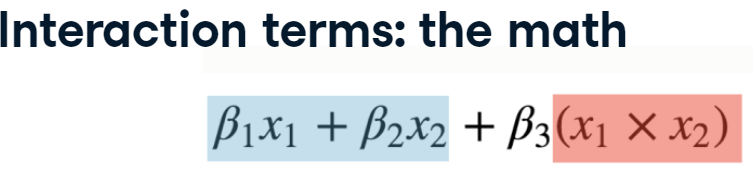

# ***Adding interaction features with scikit-learn***



In [ ]:
from sklearn.preprocessing import PolynomialFeatures

```
x

  x1 x2
a 0  1
b 1  1
```

In [ ]:
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction.fit_transform(x)



```
array([[ 0., 1., 0.],
       [ 1., 1., 1.]])
```
### ***Implement interaction modeling in scikit-learn***

It's time to add interaction features to your model. The **`PolynomialFeatures`** object in scikit-learn does just that, but here you're going to use a custom interaction object, `SparseInteractions`. Interaction terms are a statistical tool that lets your model express what happens if two features appear together in the same row.

`SparseInteractions` does the same thing as **`PolynomialFeatures`**, but it uses sparse matrices to do so. You can get the code for **`SparseInteractions`** at this [GitHub Gist](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py).

**`PolynomialFeatures`** and `SparseInteractions` both take the argument degree, which tells them what polynomial degree of interactions to compute.

You're going to consider interaction terms of **`degree=2`** in your pipeline. You will insert these steps after the preprocessing steps you've built out so far, but before the classifier steps.

Pipelines with interaction terms take a while to train (since you're making n features into n-squared features!), so as long as you set it up right, we'll do the heavy lifting and tell you what your score is!

* Add the interaction terms step using `SparseInteractions()` with **`degree=2`**. Give it a name of `'int'`, and make sure it is after the preprocessing step but before scaling.


In [23]:
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

In [ ]:
# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

Log loss score: 1.2256. Nice improvement from 1.2681!

# ***Implementing the hashing trick in scikit-learn***

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

vec = HashingVectorizer(norm=None, non_negative=True,token_pattern=TOKENS_ALPHANUMERIC,ngram_range=(1, 2))

### ***Implementing the hashing trick in scikit-learn***

In this exercise you will check out the scikit-learn implementation of **`HashingVectorizer`** before adding it to your pipeline later.

**`HashingVectorizer`** acts just like **`CountVectorizer`** in that it can accept `token_pattern` and `ngram_range` parameters. The important difference is that it creates hash values from the text, so that we get all the computational advantages of hashing!

* Instantiate the **`HashingVectorizer`** as `hashing_vec` using the `TOKENS_ALPHANUMERIC` pattern.

* Fit and transform `hashing_vec` using `text_data`. Save the result as `hashed_text`.



In [ ]:
# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Get text data: text_data
text_data = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)' 

# Instantiate the HashingVectorizer: hashing_vec
hashing_vec = HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit and transform the Hashing Vectorizer
hashed_text = hashing_vec.fit_transform(text_data)

# Create DataFrame and print the head
hashed_df = pd.DataFrame(hashed_text.data)
print(hashed_df.head())

As you can see, some text is hashed to the same value, but this doesn't neccessarily hurt performance.

### ***Build the winning model***

You have arrived! This is where all of your hard work pays off. It's time to build the model that won DrivenData's competition.

You've constructed a robust, powerful pipeline capable of processing training and testing data. Now that you understand the data and know all of the tools you need, you can essentially solve the whole problem in a relatively small number of lines of code. Wow!

All you need to do is add the **`HashingVectorizer`** step to the pipeline to replace the **`CountVectorizer`** step.

The parameters **`non_negative=True`**, **`norm=None`**, and **`binary=False`** make the **`HashingVectorizer`** perform similarly to the default settings on the **`CountVectorizer`** so you can just replace one with the other.

* Add a **`HashingVectorizer`** step to the pipeline.
* Name the step `'vectorizer'`.
* Use the `TOKENS_ALPHANUMERIC` token pattern.
* Specify the **`ngram_range`** to be `(1, 2)`


In [ ]:
# Import the hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Instantiate the winning model pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

Log loss: 1.2258. Looks like the performance is about the same, but this is expected since the **`HashingVectorizer`** should work the same as the **`CountVectorizer`**. Try this pipeline out on the whole dataset on your local machine to see its full power!